<a href="https://colab.research.google.com/github/DrAlexSanz/nlpv2-course/blob/master/Latent_Dirichlet_allocation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Use Scikit-learn's LDA for topic modelling

In [1]:
import numpy as np
import pandas as pd
import textwrap
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer # LDA is based on counts, not distributions
from sklearn.decomposition import LatentDirichletAllocation

In [4]:
nltk.download("punkt")
nltk.download("stopwords")
stops = set(stopwords.words("english"))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
stops = stops.union({"said", "could", "would", "told", "also", "one", "two", "mr", "new", "year"})
# These are generic words that appear in the output but don't add information. The second iteration (this one) refines the previous result

In [6]:
# Get the data

!wget https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv

--2022-08-15 08:34:12--  https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5085081 (4.8M) [text/csv]
Saving to: ‘bbc_text_cls.csv.1’

bbc_text_cls.csv.1  100%[===================>]   4.85M  --.-KB/s    in 0.06s   

2022-08-15 08:34:12 (80.7 MB/s) - ‘bbc_text_cls.csv.1’ saved [5085081/5085081]



In [7]:
df = pd.read_csv("bbc_text_cls.csv")

In [8]:
df.head()

,text,labels
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business


In [9]:
vectorizer = CountVectorizer(stop_words = stops)
x = vectorizer.fit_transform(df["text"])

# I could do a train-test split and validate using log-likelihood or perplextity

In [11]:
lda = LatentDirichletAllocation(n_components = 10, random_state = 12345) # Optimize the n_components if I have a business goal

In [12]:
lda.fit(x) # It takes about 20-30 seconds

LatentDirichletAllocation(random_state=12345)

In [18]:
# Now let's see what each topic contains

def plot_top_words(model, feature_names, n_top_words = 10):
    """Again 10 is arbitrary (it's the 10 components)
    
    plotting code is from sklearn docs
    """
    fig, axes = plt.subplots(2, 5, figsize = (30, 15), sharex = True)
    axes = axes.flatten()

    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height = 0.7)
        ax.set_title(f"Topic {topic_idx + 1}", fontdict = {"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis = "both", which = "major", labelsize = 20)

        for i in "top right left".split():
            ax.spines[i].set_visible(False)

        fig.suptitle("LDA", fontsize = 40)

    return

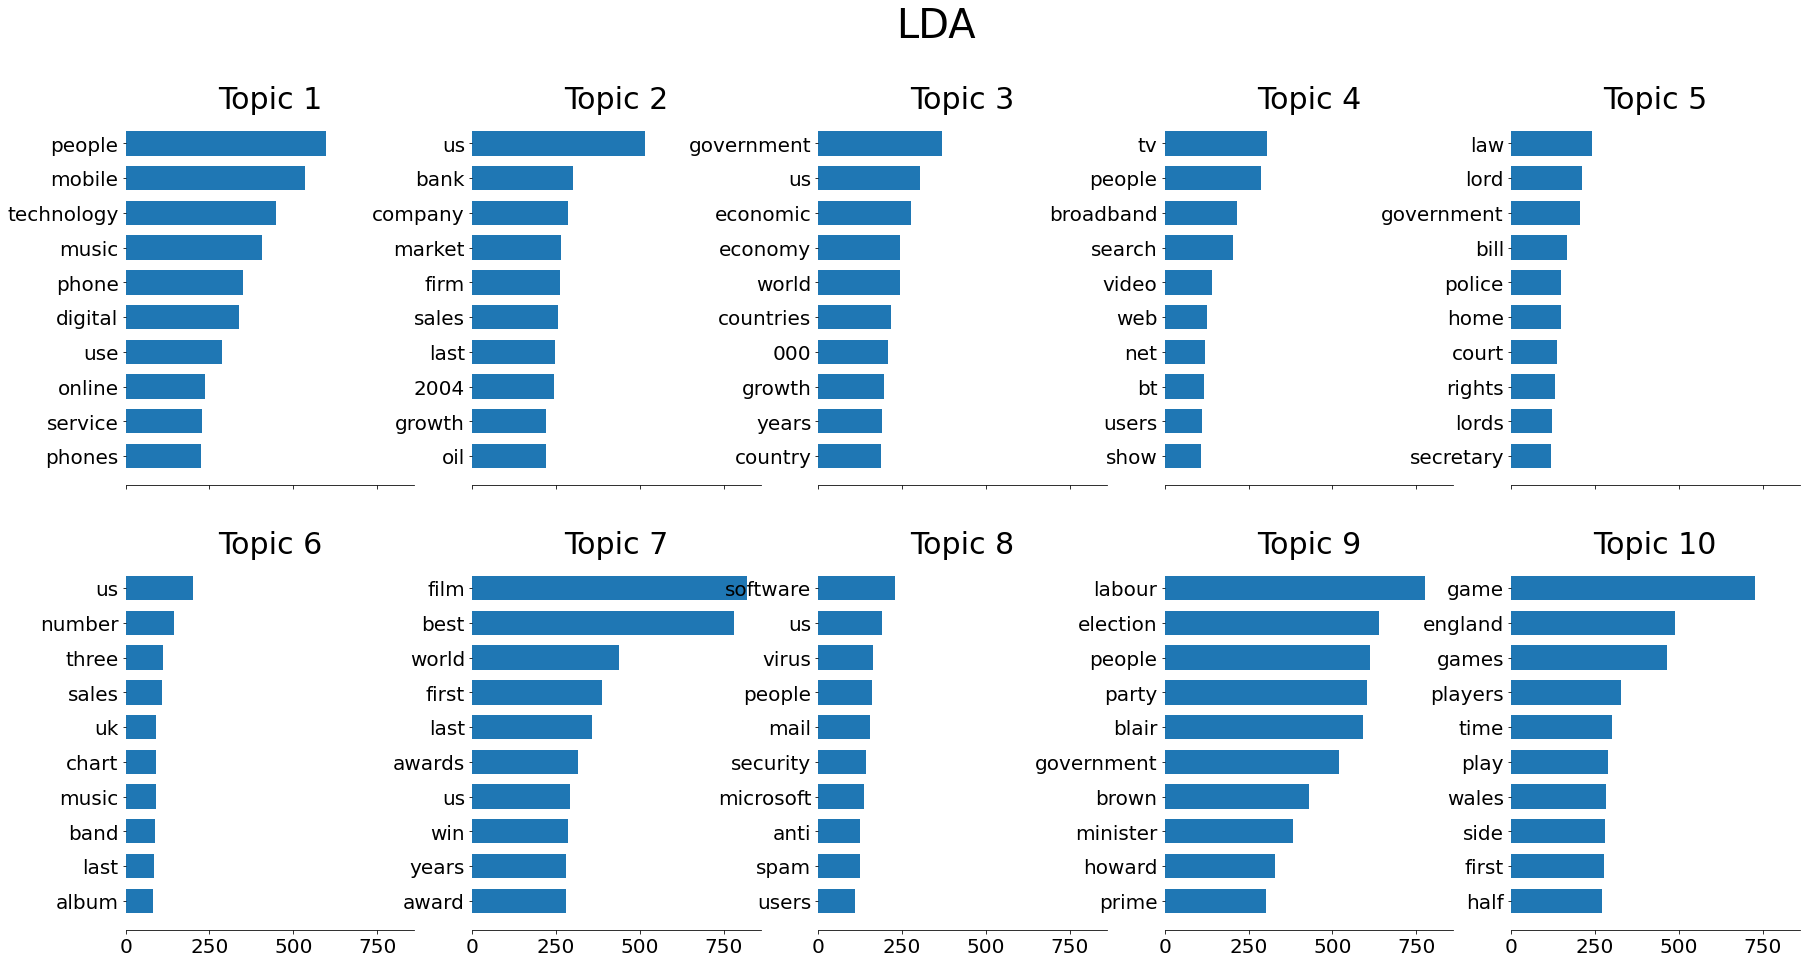

In [19]:
# I can see that topic 2 seems to be economy, topic 3 is domestic politics, topic 4 is entertainment... But since this is unsupervised I didn't define which topics I wanted. In a way it's similar to KMeans clustering.
# This is "which words form a topic?"


feature_names = vectorizer.get_feature_names_out() # I didn't create the word to index mapping myself, but it's available in the model.

plot_top_words(lda, feature_names)

# I can probably refine the stopwords a bit. And in this case I can check the labels too.

In [20]:
z = lda.transform(x) # Let's see the documents by topic. In other words, pick a document and see which topics are associated with it.

In [21]:
np.random.seed(0)
i = np.random.choice(len(df))
doc = z[i]
topics = np.arange(10) + 1

Text(0.5, 1.0, 'True label: sport')

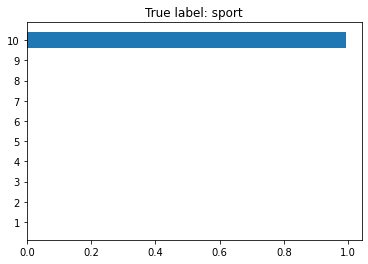

In [27]:
fig, ax = plt.subplots()
ax.barh(topics, doc)
ax.set_yticks(topics)
ax.set_title("True label: %s" %df.iloc[i]["labels"])
# In this case all the probability goes to 10. It's sports, looking at the previous plot.

In [28]:
# Let's print the article to see if it makes sense

def wrap_article(article):
    return textwrap.fill(article, replace_whitespace = False, fix_sentence_endings = True)

In [30]:
print(wrap_article(df.iloc[i]["text"])) # And it looks like sports, because it speaks about the Six Nations

Charvis set to lose fitness bid

Flanker Colin Charvis is unlikely to
play any part in Wales' final two games of the Six Nations.

Charvis
has missed all three of Wales' victories with an ankle injury and his
recovery has been slower than expected.  "He will not figure in the
Scotland game and is now thought unlikely to be ready for the final
game," said Wales physio Mark Davies.  Sonny Parker is continuing to
struggle with a neck injury, but Hal Luscombe should be fit for the
Murrayfield trip.  Centre Parker has only a "slim chance" of being
involved against the Scots on 13 March, so Luscombe's return to
fitness after missing the France match with hamstring trouble is a
timely boost.

Said Wales assistant coach Scott Johnson: "We're
positive about Hal and hope he'll be raring to go.  "He comes back
into the mix again, adds to the depth and gives us other options.  "
Replacement hooker Robin McBryde remains a doubt after picking up knee
ligament damage in Paris last Saturday.  "We're g

Text(0.5, 1.0, 'True label: sport')

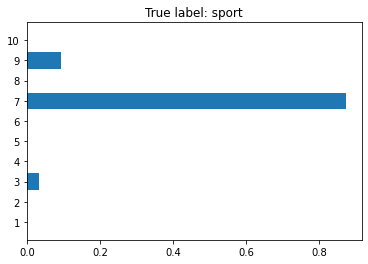

In [31]:
# Do another article

j = np.random.choice(len(df))
doc = z[j]

fig, ax = plt.subplots()
ax.barh(topics, doc)
ax.set_yticks(topics)
ax.set_title("True label: %s" %df.iloc[i]["labels"])

In [33]:
print(wrap_article(df.iloc[j]["text"])) # And it's about the Oscars but it touches a bit of politics when mentioning Mel Gibson and Michael Moore. It probably finds the $ signs and assigns it a bit to the economy topic.

Oscars steer clear of controversy

The Oscars nominations list has
left out some of the most controversial films of the past year in
favour of safer, less contentious cinema.

If best film nominees were
drawn on the basis of column inches, two of the front-runners would
have had to be Michael Moore's Bush-baiting documentary Fahrenheit
9/11 and Mel Gibson's The Passion of the Christ.  Both films polarised
opinion but had critics talking, and the public turning up to see them
- Fahrenheit 9/11 breaking US box office records for a documentary,
and The Passion of the Christ making more than US$370m (£196m) in the
US alone.  But this year's Academy Awards have shied away from the big
name controversies, with The Passion of the Christ - a film accused of
being anti-Semitic - receiving nominations only in the 'minor'
categories of cinematography, makeup and musical score.

Fahrenheit
9/11 has also been overlooked, despite winning the Palme d'Or at the
Cannes International Film Festival in 20